## Bibliotecas

In [ ]:
!pip install deepxde

import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
import random
import seaborn as sns
import csv
import pickle

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.1 MB/s eta 0:00:00


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



## Problema Direto


---

Determinar $\phi$ no interior e, principalmente, nos eletrodos, assumindo que $\sigma$, no interior, e $J$, no contorno, sejam conhecidos.

$$
\nabla \cdot \left ( \sigma \nabla \phi \right ) = 0
$$

$$
\sigma\dfrac{\partial \phi}{\partial \hat n}\Bigr\rvert_{\partial\Omega} =J_{\partial\Omega}
$$



### Funções usadas

In [ ]:
# função que define a condutividade elétrica no domínio
def fct_sigma(u):
  return 0.3815

# equação diferencial
def pde(u, q):
  phi = q[:,0:1]
  sigma = fct_sigma(u)
  gradient_x = sigma*dde.grad.jacobian(phi, u, i=0, j=0)
  gradient_y = sigma*dde.grad.jacobian(phi, u, i=0, j=1)
  divergent = dde.grad.jacobian(gradient_x, u, i=0, j=0) + dde.grad.jacobian(gradient_y, u, i=0, j=1)
  return divergent

# calcula o vetor normal a um ponto da circunferência
def outer_normal_vector(u):
  x_component = u[:,0:1]/((u[:,0:1]**2+u[:,1:2]**2)**(1/2))
  y_component = u[:,1:2]/((u[:,0:1]**2+u[:,1:2]**2)**(1/2))
  return [x_component, y_component]

# bc nos eletrodos de entrada
def fct_entry_eletrode(u, q, _):
  J = 190*1e-3
  # eletrodo de entrada
  current = J
  # eletrodo de saída
  phi = q[:,0:1]
  sigma = fct_sigma(u)
  # sigma x derivada direcional - J
  outer_vec_entry = outer_normal_vector(u)
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_entry[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_entry[1]) - J
  return ans

# bc nos eletrodos de saída
def fct_exit_eletrode(u, q, _):
  J = 190*1e-3
  # eletrodo de entrada
  current = -J
  # eletrodo de saída
  phi = q[:,0:1]
  sigma = fct_sigma(u)
  # sigma x derivada direcional - J
  outer_vec_entry = outer_normal_vector(u)
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_entry[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_entry[1]) - current
  return ans

# bc nos outros eletrodos
def fct_other_eletrodes(u, q, _):
  J = 0
  # eletrodo de entrada
  current = 0
  # eletrodo de saída
  phi = q[:,0:1]
  sigma = fct_sigma(u)
  # sigma x derivada direcional - J
  outer_vec_others = outer_normal_vector(u)
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_others[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_others[1]) - current
  return ans

# bc fora dos eletrodos
def fct_not_eletrode(u, q, _):
  J = 0
  # eletrodo de entrada
  current = 0
  # eletrodo de saída
  phi = q[:,0:1]
  sigma = fct_sigma(u)
  # sigma x derivada direcional - J
  outer_vec_not = [0,0]
  # sigma x derivada direcional - J
  ans = sigma*(dde.grad.jacobian(phi, u, i=0, j=0)*outer_vec_not[0] + dde.grad.jacobian(phi, u, i=0, j=1)*outer_vec_not[1]) - current
  return ans

# identifica o eletrodo de entrada
def entry_eletrode(x, on_boundary):
  global entry_eletrode_values
  return on_boundary and np.allclose(x, entry_eletrode_values)

# identifica o eletrodo de saída
def exit_eletrode(x, on_boundary):
  global exit_eletrode_values
  return on_boundary and np.allclose(x, exit_eletrode_values)

# identifica se o eletrodo não é de entrada nem de saída
def other_eletrodes(x, on_boundary):
  global entry_eletrode_values, exit_eletrode_values, eletrodes
  return on_boundary and not(np.allclose(x, entry_eletrode_values) or np.allclose(x, exit_eletrode_values)) and is_eletrode(x)

# não é eletrodo
def not_eletrode(x, on_boundary):
  return on_boundary and not(is_eletrode(x))

# verifica se é eletrodo
def is_eletrode(x):
  global eletrodes
  for eletrode in eletrodes:
    if np.allclose(x, eletrode):
      return True
  return False

### Montagem da rede neural

In [ ]:
def neural_network(i, geom, eletrodes):
  # condição de contorno
  bc_entry_eletrode = dde.OperatorBC(geom, fct_entry_eletrode, entry_eletrode)
  bc_exit_eletrode = dde.OperatorBC(geom, fct_exit_eletrode, exit_eletrode)
  bc_other_eletrodes = dde.OperatorBC(geom, fct_other_eletrodes, other_eletrodes)
  bc_not_eletrodes = dde.OperatorBC(geom, fct_not_eletrode, not_eletrode)

  # fixando que o eletrodo na posição (0.15, 0) tem potencial nulo
  observe_potential = dde.icbc.PointSetBC(eletrodes[np.shape(eletrodes)[0]//2], [0])

  # criando o conjunto de dados
  data = dde.data.PDE(geom, pde, [bc_entry_eletrode, bc_exit_eletrode, bc_other_eletrodes, bc_not_eletrodes, observe_potential], num_domain=500, num_boundary=200, anchors=eletrodes, num_test=100)

  activation = "tanh"

  # criando a rede
  net = dde.nn.PFNN([2] + [30,30]*3 + [1], activation = activation, kernel_initializer = "Glorot uniform")

  #treinando o modelo
  model = dde.Model(data, net)
  loss_weights = [1, 150, 150, 100, 100, 100]
  model.compile(optimizer='adam', lr=0.001, loss_weights = loss_weights)

  # calculando o erro
  losshistory, train_state = model.train(iterations=30000, display_every=10000)

  dde.saveplot(losshistory, train_state, issave=True, isplot=True)

  return model

### Eletrodos

0
Compiling model...
Building feed-forward neural network...
'build' took 0.178194 s

'compile' took 3.876188 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.59e-03, 3.64e+00, 1.51e+00, 2.55e-01, 0.00e+00, 1.06e-01]    [1.28e-03, 3.64e+00, 1.51e+00, 2.55e-01, 0.00e+00, 8.59e-02]    []  
10000     [7.87e-04, 9.90e-05, 7.16e-07, 1.29e-03, 0.00e+00, 2.12e-03]    [1.15e-03, 9.90e-05, 7.16e-07, 1.29e-03, 0.00e+00, 2.42e-03]    []  
20000     [6.42e-04, 6.21e-04, 1.82e-04, 1.11e-03, 0.00e+00, 1.78e-03]    [3.12e-04, 6.21e-04, 1.82e-04, 1.11e-03, 0.00e+00, 1.73e-03]    []  
30000     [9.22e-04, 1.72e-05, 6.28e-07, 9.08e-04, 0.00e+00, 2.15e-03]    [8.59e-04, 1.72e-05, 6.28e-07, 9.08e-04, 0.00e+00, 3.05e-03]    []  

Best model at step 30000:
  train loss: 4.00e-03
  test loss: 4.84e-03
  test metric: []

'train' took 100.533756 s

Saving loss history to /cont

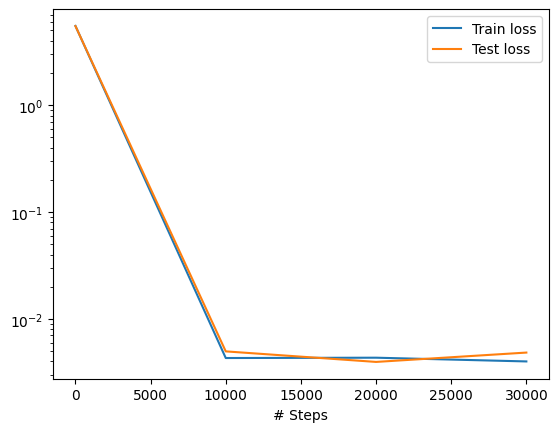

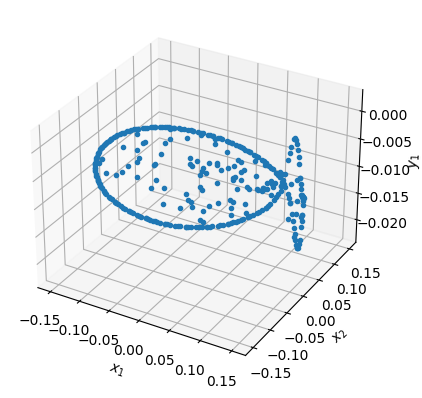

1
Compiling model...
Building feed-forward neural network...
'build' took 0.123106 s

'compile' took 2.936723 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.47e-03, 8.99e-01, 7.40e+00, 1.36e+00, 0.00e+00, 2.00e-03]    [7.00e-03, 8.99e-01, 7.40e+00, 1.36e+00, 0.00e+00, 6.96e-02]    []  
10000     [2.20e-03, 3.40e-04, 4.15e-04, 2.03e-03, 0.00e+00, 1.13e-03]    [1.10e-03, 3.40e-04, 4.15e-04, 2.03e-03, 0.00e+00, 1.04e-03]    []  
20000     [1.76e-03, 8.09e-06, 1.20e-04, 5.93e-04, 0.00e+00, 6.18e-04]    [6.48e-04, 8.09e-06, 1.20e-04, 5.93e-04, 0.00e+00, 1.03e-03]    []  
30000     [3.28e-04, 5.31e-05, 5.93e-06, 3.67e-04, 0.00e+00, 4.27e-04]    [5.14e-05, 5.31e-05, 5.93e-06, 3.67e-04, 0.00e+00, 1.29e-03]    []  

Best model at step 30000:
  train loss: 1.18e-03
  test loss: 1.76e-03
  test metric: []

'train' took 94.184899 s

Saving loss history to /conte

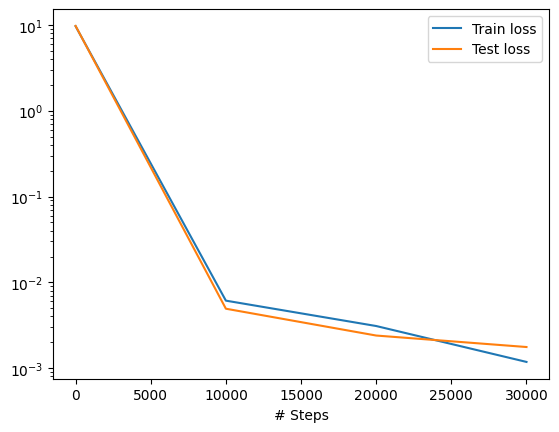

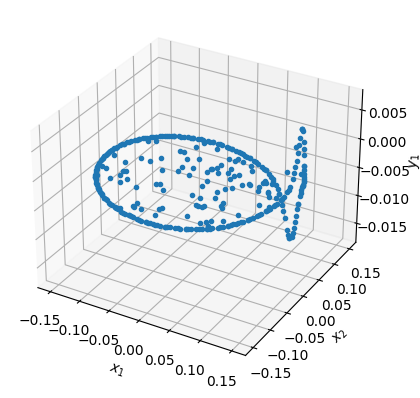

2
Compiling model...
Building feed-forward neural network...
'build' took 0.135074 s

'compile' took 3.061099 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.48e-03, 9.60e+00, 5.79e-01, 1.88e+00, 0.00e+00, 1.24e+00]    [6.26e-03, 9.60e+00, 5.79e-01, 1.88e+00, 0.00e+00, 8.14e-01]    []  
10000     [6.82e-04, 1.84e-04, 1.72e-04, 1.09e-03, 0.00e+00, 1.17e-04]    [1.96e-04, 1.84e-04, 1.72e-04, 1.09e-03, 0.00e+00, 2.81e-04]    []  
20000     [4.70e-04, 1.52e-04, 2.38e-05, 2.32e-04, 0.00e+00, 1.25e-03]    [1.70e-04, 1.52e-04, 2.38e-05, 2.32e-04, 0.00e+00, 2.39e-03]    []  
30000     [1.93e-03, 3.07e-04, 5.63e-04, 1.05e-03, 0.00e+00, 2.54e-03]    [1.00e-03, 3.07e-04, 5.63e-04, 1.05e-03, 0.00e+00, 4.21e-03]    []  

Best model at step 20000:
  train loss: 2.13e-03
  test loss: 2.97e-03
  test metric: []

'train' took 96.106465 s

Saving loss history to /conte

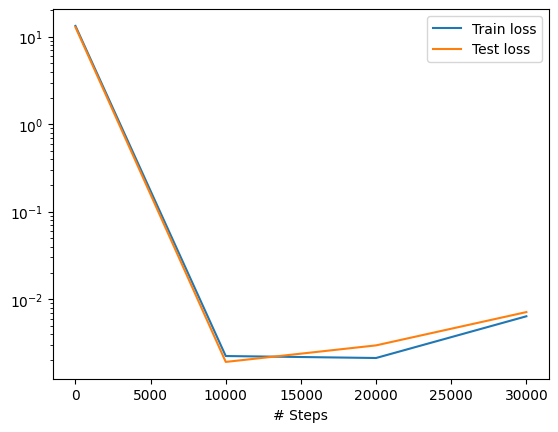

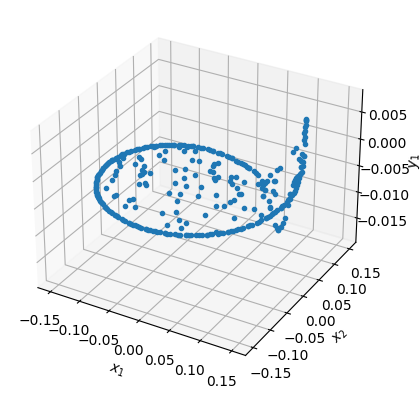

3
Compiling model...
Building feed-forward neural network...
'build' took 0.130402 s

'compile' took 3.095062 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.81e-03, 3.80e+00, 2.94e+00, 8.26e-01, 0.00e+00, 4.03e-01]    [1.94e-03, 3.80e+00, 2.94e+00, 8.26e-01, 0.00e+00, 3.78e-01]    []  
10000     [6.36e-03, 3.94e-05, 3.55e-04, 1.97e-02, 0.00e+00, 1.32e-04]    [4.07e-03, 3.94e-05, 3.55e-04, 1.97e-02, 0.00e+00, 8.42e-05]    []  
20000     [3.22e-03, 3.39e-03, 3.49e-04, 1.81e-03, 0.00e+00, 4.05e-04]    [1.03e-03, 3.39e-03, 3.49e-04, 1.81e-03, 0.00e+00, 1.25e-04]    []  
30000     [6.08e-04, 1.20e-04, 5.27e-04, 1.81e-04, 0.00e+00, 2.40e-04]    [3.09e-04, 1.20e-04, 5.27e-04, 1.81e-04, 0.00e+00, 9.92e-04]    []  

Best model at step 30000:
  train loss: 1.67e-03
  test loss: 2.13e-03
  test metric: []

'train' took 95.674119 s

Saving loss history to /conte

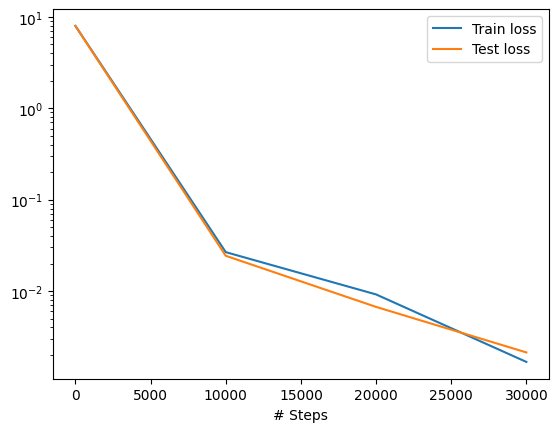

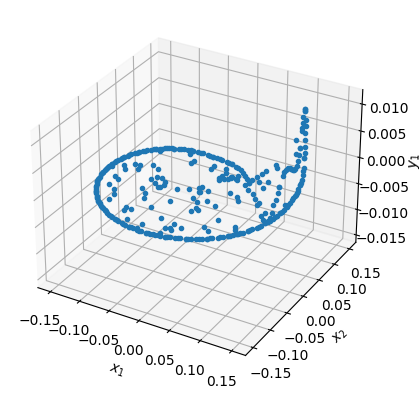

4
Compiling model...
Building feed-forward neural network...
'build' took 0.125049 s

'compile' took 3.129994 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.90e-04, 3.59e+00, 2.93e-01, 3.24e-01, 0.00e+00, 3.20e-04]    [6.13e-04, 3.59e+00, 2.93e-01, 3.24e-01, 0.00e+00, 3.66e-04]    []  
10000     [6.34e-04, 5.49e-06, 5.63e-06, 6.76e-04, 0.00e+00, 1.91e-04]    [3.15e-04, 5.49e-06, 5.63e-06, 6.76e-04, 0.00e+00, 1.63e-04]    []  
20000     [9.66e-05, 3.12e-07, 4.85e-06, 1.39e-04, 0.00e+00, 2.22e-04]    [1.21e-04, 3.11e-07, 4.85e-06, 1.39e-04, 0.00e+00, 1.78e-04]    []  
30000     [2.03e-04, 4.14e-04, 3.77e-04, 1.23e-04, 0.00e+00, 1.82e-04]    [1.33e-04, 4.14e-04, 3.77e-04, 1.23e-04, 0.00e+00, 1.56e-04]    []  

Best model at step 20000:
  train loss: 4.62e-04
  test loss: 4.42e-04
  test metric: []

'train' took 94.991406 s

Saving loss history to /conte

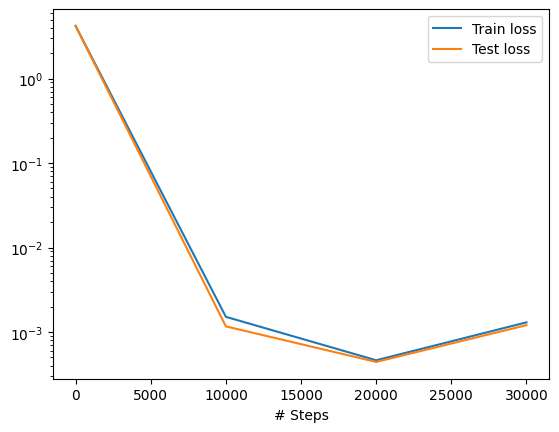

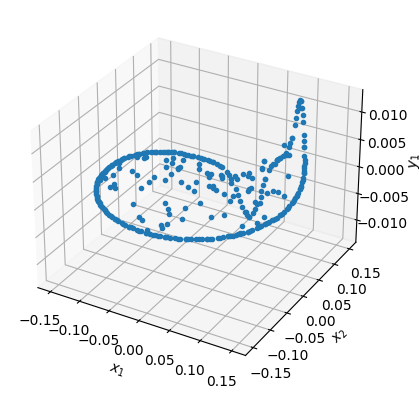

5
Compiling model...
Building feed-forward neural network...
'build' took 0.135425 s

'compile' took 4.471153 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.12e-03, 2.74e+00, 5.24e-02, 8.60e-01, 0.00e+00, 2.45e-01]    [7.67e-04, 2.74e+00, 5.24e-02, 8.60e-01, 0.00e+00, 2.15e-01]    []  
10000     [9.34e-03, 5.60e-04, 4.45e-04, 7.80e-04, 0.00e+00, 1.60e-03]    [1.49e-03, 5.60e-04, 4.45e-04, 7.80e-04, 0.00e+00, 1.53e-03]    []  
20000     [4.76e-04, 4.80e-06, 6.99e-06, 2.53e-04, 0.00e+00, 3.98e-04]    [1.22e-04, 4.80e-06, 6.99e-06, 2.53e-04, 0.00e+00, 3.87e-04]    []  
30000     [5.59e-04, 5.24e-04, 6.88e-04, 2.00e-04, 0.00e+00, 1.59e-04]    [1.37e-04, 5.24e-04, 6.88e-04, 2.00e-04, 0.00e+00, 1.69e-04]    []  

Best model at step 20000:
  train loss: 1.14e-03
  test loss: 7.74e-04
  test metric: []

'train' took 96.222711 s

Saving loss history to /conte

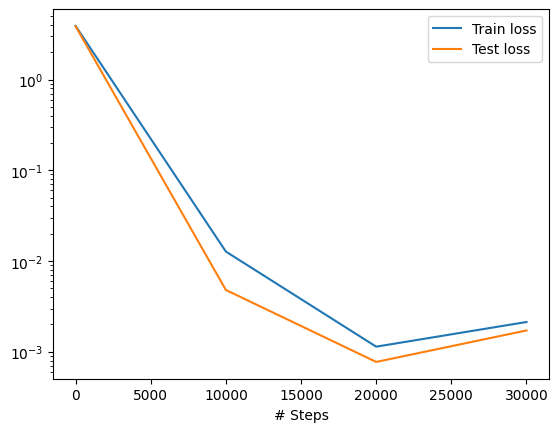

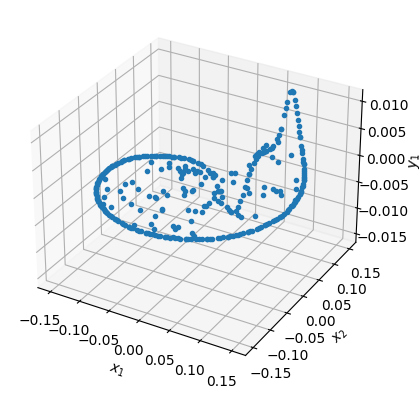

6
Compiling model...
Building feed-forward neural network...
'build' took 0.129878 s

'compile' took 3.661446 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.03e-03, 6.07e+00, 3.59e-01, 1.94e+00, 0.00e+00, 3.76e-01]    [7.02e-03, 6.07e+00, 3.59e-01, 1.94e+00, 0.00e+00, 2.46e-01]    []  
10000     [6.02e-04, 1.51e-05, 7.20e-05, 7.93e-04, 0.00e+00, 1.52e-04]    [3.41e-04, 1.51e-05, 7.20e-05, 7.93e-04, 0.00e+00, 1.15e-04]    []  
20000     [1.93e-04, 7.42e-05, 1.50e-06, 1.65e-04, 0.00e+00, 3.19e-04]    [8.04e-05, 7.42e-05, 1.50e-06, 1.65e-04, 0.00e+00, 3.19e-04]    []  
30000     [2.47e-04, 7.88e-04, 8.21e-04, 1.14e-04, 0.00e+00, 2.31e-04]    [8.10e-05, 7.88e-04, 8.21e-04, 1.14e-04, 0.00e+00, 2.37e-04]    []  

Best model at step 20000:
  train loss: 7.52e-04
  test loss: 6.40e-04
  test metric: []

'train' took 94.732405 s

Saving loss history to /conte

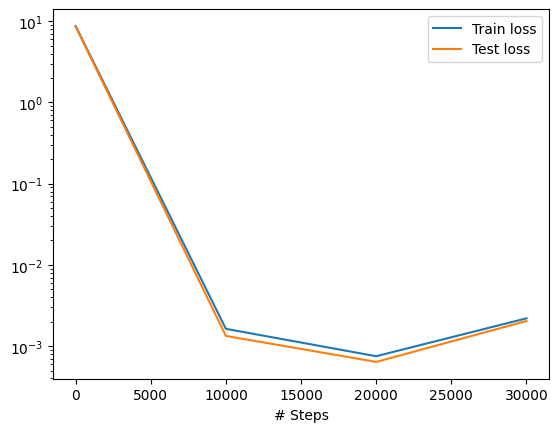

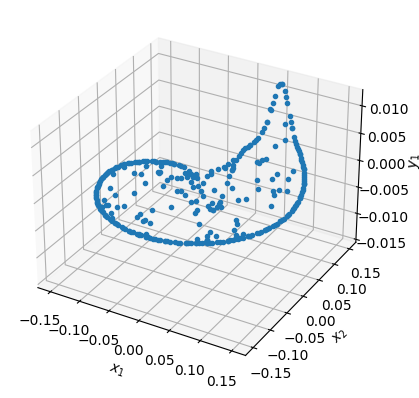

7
Compiling model...
Building feed-forward neural network...
'build' took 0.127011 s

'compile' took 4.323086 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.15e-03, 5.52e+00, 2.63e-01, 1.79e+00, 0.00e+00, 6.22e-01]    [3.85e-03, 5.52e+00, 2.63e-01, 1.79e+00, 0.00e+00, 3.22e-01]    []  
10000     [7.60e-03, 4.36e-03, 1.01e-03, 2.78e-03, 0.00e+00, 3.55e-04]    [4.68e-03, 4.36e-03, 1.01e-03, 2.78e-03, 0.00e+00, 3.45e-04]    []  
20000     [2.77e-04, 4.97e-05, 1.31e-04, 1.52e-04, 0.00e+00, 1.46e-04]    [1.97e-04, 4.97e-05, 1.31e-04, 1.52e-04, 0.00e+00, 4.51e-05]    []  
30000     [7.37e-05, 7.91e-06, 6.43e-05, 9.60e-05, 0.00e+00, 2.01e-04]    [1.71e-04, 7.91e-06, 6.43e-05, 9.60e-05, 0.00e+00, 4.38e-05]    []  

Best model at step 30000:
  train loss: 4.43e-04
  test loss: 3.83e-04
  test metric: []

'train' took 94.487375 s

Saving loss history to /conte

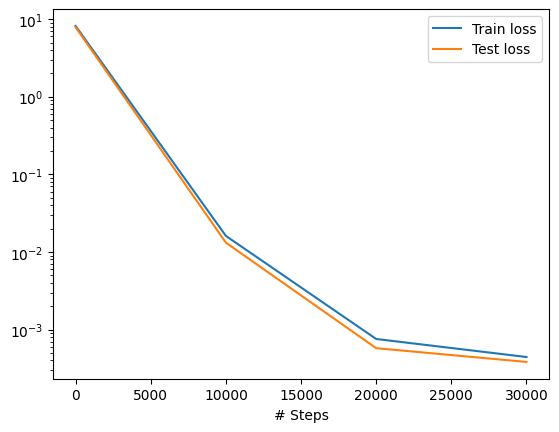

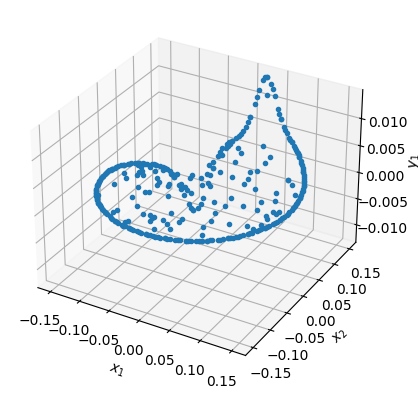

8
Compiling model...
Building feed-forward neural network...
'build' took 0.179586 s

'compile' took 3.539596 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.48e-04, 6.40e-01, 1.35e+00, 4.81e-01, 0.00e+00, 2.01e-01]    [4.20e-04, 6.40e-01, 1.35e+00, 4.81e-01, 0.00e+00, 1.13e-01]    []  
10000     [4.63e-03, 3.02e-03, 3.13e-03, 1.27e-03, 0.00e+00, 8.26e-04]    [7.29e-04, 3.02e-03, 3.13e-03, 1.27e-03, 0.00e+00, 8.41e-04]    []  
20000     [6.35e-04, 1.19e-04, 2.44e-03, 3.03e-04, 0.00e+00, 5.26e-03]    [2.11e-04, 1.19e-04, 2.44e-03, 3.03e-04, 0.00e+00, 5.75e-03]    []  
30000     [1.78e-03, 4.22e-07, 1.36e-05, 1.42e-04, 0.00e+00, 4.25e-04]    [3.01e-04, 4.22e-07, 1.36e-05, 1.42e-04, 0.00e+00, 2.86e-04]    []  

Best model at step 30000:
  train loss: 2.36e-03
  test loss: 7.43e-04
  test metric: []

'train' took 95.428174 s

Saving loss history to /conte

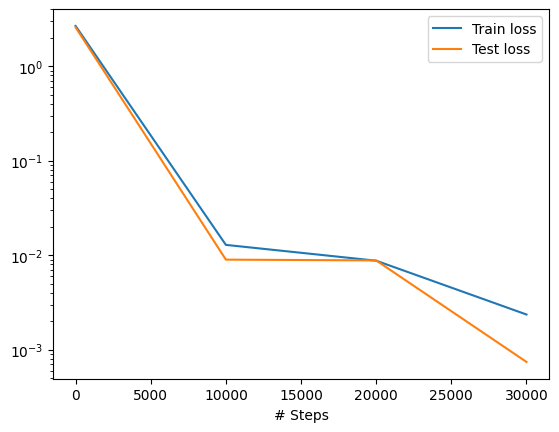

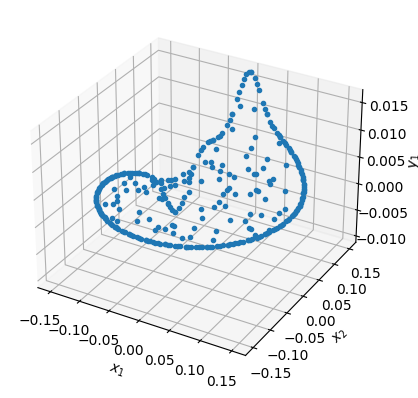

9
Compiling model...
Building feed-forward neural network...
'build' took 0.184596 s

'compile' took 5.248596 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.09e-08, 1.75e+00, 1.71e+00, 2.87e-03, 0.00e+00, 1.35e-03]    [1.51e-08, 1.75e+00, 1.71e+00, 2.87e-03, 0.00e+00, 6.75e-04]    []  
10000     [9.89e-04, 1.69e-03, 1.38e-03, 7.65e-04, 0.00e+00, 5.27e-05]    [6.26e-04, 1.69e-03, 1.38e-03, 7.65e-04, 0.00e+00, 2.82e-05]    []  
20000     [2.09e-03, 3.47e-05, 4.68e-04, 3.24e-04, 0.00e+00, 4.14e-04]    [6.16e-04, 3.47e-05, 4.68e-04, 3.24e-04, 0.00e+00, 4.14e-04]    []  
30000     [1.12e-03, 1.02e-05, 1.21e-05, 1.28e-04, 0.00e+00, 1.69e-04]    [3.71e-04, 1.02e-05, 1.21e-05, 1.28e-04, 0.00e+00, 1.19e-04]    []  

Best model at step 30000:
  train loss: 1.44e-03
  test loss: 6.40e-04
  test metric: []

'train' took 96.273021 s

Saving loss history to /conte

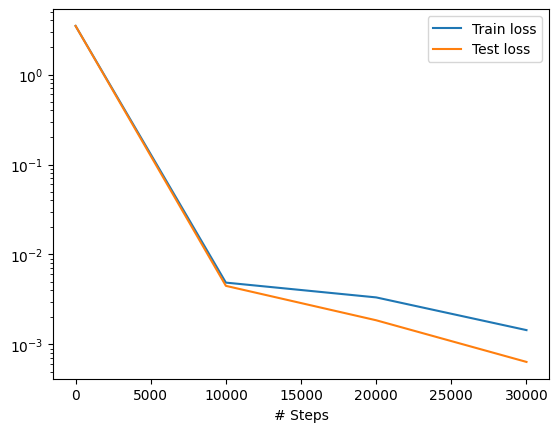

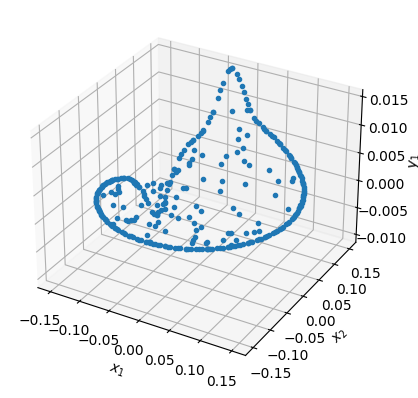

10
Compiling model...
Building feed-forward neural network...
'build' took 0.137587 s

'compile' took 3.477958 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.13e-03, 6.97e-01, 4.02e+00, 2.08e-01, 0.00e+00, 1.14e-01]    [1.02e-03, 6.97e-01, 4.02e+00, 2.08e-01, 0.00e+00, 5.78e-02]    []  
10000     [1.75e-03, 5.43e-04, 8.41e-05, 9.81e-04, 0.00e+00, 7.75e-04]    [6.38e-04, 5.43e-04, 8.41e-05, 9.81e-04, 0.00e+00, 2.16e-03]    []  
20000     [2.70e-04, 9.45e-05, 2.05e-04, 2.61e-04, 0.00e+00, 1.27e-03]    [1.37e-04, 9.45e-05, 2.05e-04, 2.61e-04, 0.00e+00, 3.08e-03]    []  
30000     [3.14e-04, 2.58e-05, 1.19e-05, 1.78e-04, 0.00e+00, 4.16e-04]    [1.64e-04, 2.58e-05, 1.19e-05, 1.78e-04, 0.00e+00, 8.54e-04]    []  

Best model at step 30000:
  train loss: 9.45e-04
  test loss: 1.23e-03
  test metric: []

'train' took 96.282188 s

Saving loss history to /cont

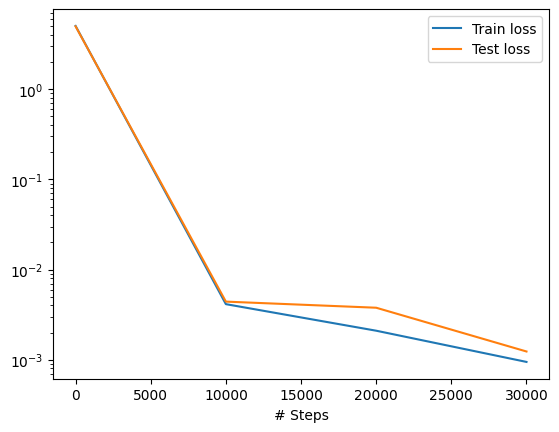

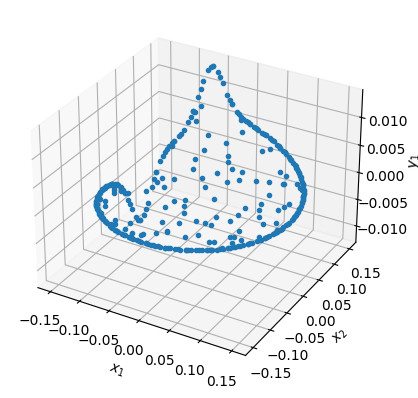

11
Compiling model...
Building feed-forward neural network...
'build' took 0.145171 s

'compile' took 3.526645 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.89e-04, 2.03e+00, 2.97e+00, 2.00e-01, 0.00e+00, 7.06e-02]    [3.40e-04, 2.03e+00, 2.97e+00, 2.00e-01, 0.00e+00, 4.24e-02]    []  
10000     [3.35e-03, 1.96e-03, 1.54e-03, 1.04e-01, 0.00e+00, 4.52e-03]    [2.47e-03, 1.96e-03, 1.54e-03, 1.04e-01, 0.00e+00, 5.70e-03]    []  
20000     [7.88e-04, 1.54e-03, 1.22e-03, 3.05e-04, 0.00e+00, 9.38e-04]    [2.23e-04, 1.54e-03, 1.22e-03, 3.05e-04, 0.00e+00, 9.37e-04]    []  
30000     [3.33e-04, 1.29e-07, 5.39e-07, 3.73e-04, 0.00e+00, 5.57e-04]    [1.28e-04, 1.29e-07, 5.38e-07, 3.73e-04, 0.00e+00, 6.44e-04]    []  

Best model at step 30000:
  train loss: 1.26e-03
  test loss: 1.15e-03
  test metric: []

'train' took 96.385290 s

Saving loss history to /cont

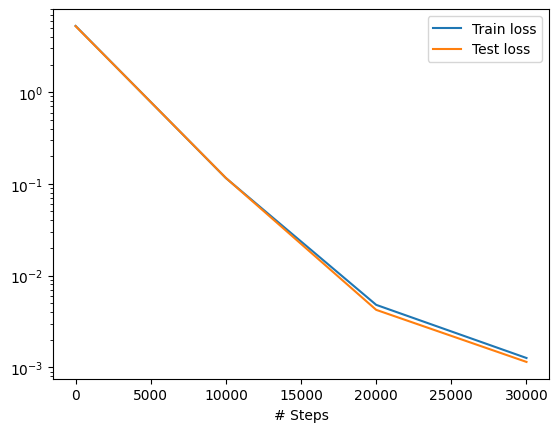

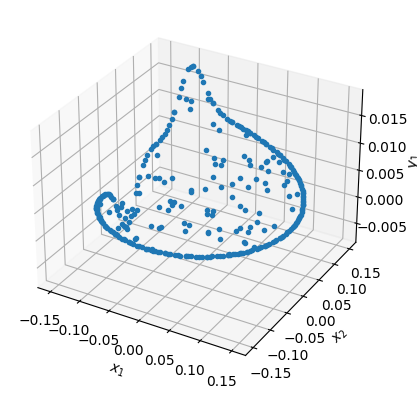

12
Compiling model...
Building feed-forward neural network...
'build' took 0.132532 s

'compile' took 3.588060 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.53e-03, 1.77e+00, 4.38e+00, 5.95e-01, 0.00e+00, 1.91e-01]    [3.69e-03, 1.77e+00, 4.38e+00, 5.95e-01, 0.00e+00, 9.98e-02]    []  
10000     [1.21e-03, 9.31e-06, 5.28e-06, 1.56e-03, 0.00e+00, 1.86e-03]    [5.85e-04, 9.31e-06, 5.28e-06, 1.56e-03, 0.00e+00, 2.53e-03]    []  
20000     [8.28e-03, 3.72e-04, 1.11e-04, 1.43e-03, 0.00e+00, 2.94e-03]    [4.58e-03, 3.72e-04, 1.11e-04, 1.43e-03, 0.00e+00, 3.09e-03]    []  
30000     [1.49e-03, 8.21e-06, 1.67e-05, 1.54e-03, 0.00e+00, 2.39e-03]    [1.23e-03, 8.21e-06, 1.67e-05, 1.54e-03, 0.00e+00, 2.82e-03]    []  

Best model at step 10000:
  train loss: 4.64e-03
  test loss: 4.69e-03
  test metric: []

'train' took 97.003266 s

Saving loss history to /cont

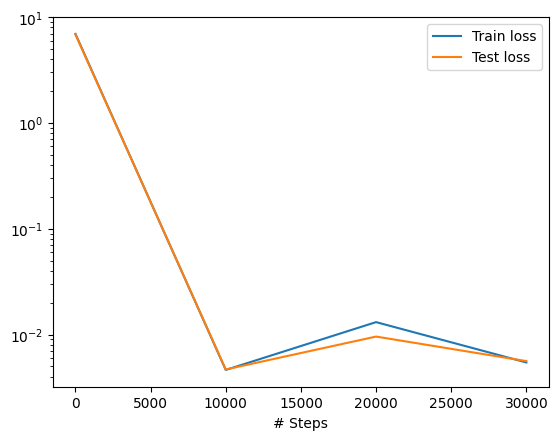

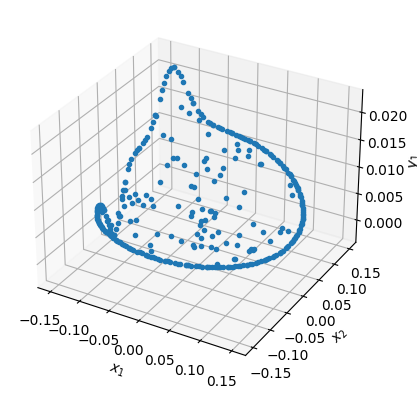

13
Compiling model...
Building feed-forward neural network...
'build' took 0.130500 s

'compile' took 3.699947 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.06e-04, 3.07e+00, 5.02e-01, 1.92e-01, 0.00e+00, 1.18e-01]    [1.91e-04, 3.07e+00, 5.02e-01, 1.92e-01, 0.00e+00, 6.10e-02]    []  
10000     [5.18e-03, 2.22e-04, 1.63e-04, 9.50e-04, 0.00e+00, 2.83e-04]    [2.07e-03, 2.22e-04, 1.63e-04, 9.50e-04, 0.00e+00, 1.70e-03]    []  
20000     [2.06e-03, 5.79e-05, 3.27e-04, 3.29e-04, 0.00e+00, 1.50e-03]    [8.31e-04, 5.79e-05, 3.27e-04, 3.29e-04, 0.00e+00, 4.42e-03]    []  
30000     [2.41e-03, 1.71e-04, 7.68e-06, 4.29e-04, 0.00e+00, 3.00e-04]    [1.26e-03, 1.71e-04, 7.68e-06, 4.29e-04, 0.00e+00, 1.79e-03]    []  

Best model at step 30000:
  train loss: 3.32e-03
  test loss: 3.65e-03
  test metric: []

'train' took 97.116363 s

Saving loss history to /cont

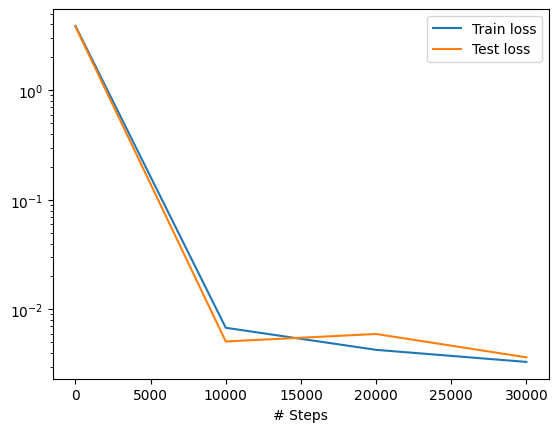

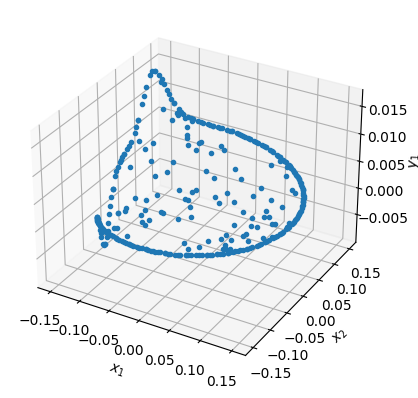

14
Compiling model...
Building feed-forward neural network...
'build' took 0.127664 s

'compile' took 6.102470 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.00e-05, 1.69e+00, 1.63e+00, 1.09e-02, 0.00e+00, 6.68e-05]    [3.98e-05, 1.69e+00, 1.63e+00, 1.09e-02, 0.00e+00, 3.69e-05]    []  
10000     [5.20e-03, 2.46e-06, 3.41e-05, 3.67e-03, 0.00e+00, 1.86e-05]    [2.32e-03, 2.46e-06, 3.41e-05, 3.67e-03, 0.00e+00, 1.20e-05]    []  
20000     [3.13e-04, 2.68e-04, 1.97e-04, 1.64e-04, 0.00e+00, 1.07e-04]    [1.05e-04, 2.68e-04, 1.97e-04, 1.64e-04, 0.00e+00, 9.46e-05]    []  
30000     [1.60e-03, 2.90e-05, 3.72e-04, 1.13e-04, 0.00e+00, 7.70e-05]    [6.86e-04, 2.90e-05, 3.72e-04, 1.13e-04, 0.00e+00, 6.41e-05]    []  

Best model at step 20000:
  train loss: 1.05e-03
  test loss: 8.28e-04
  test metric: []

'train' took 98.566955 s

Saving loss history to /cont

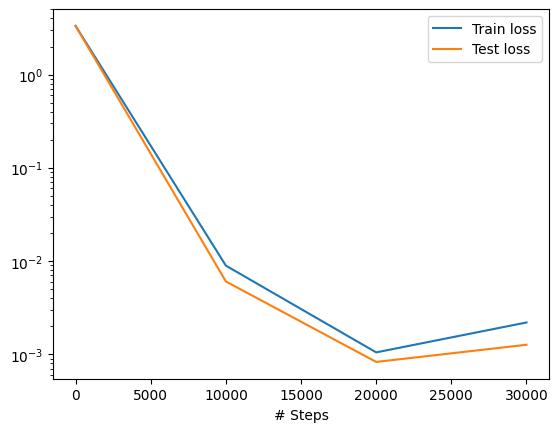

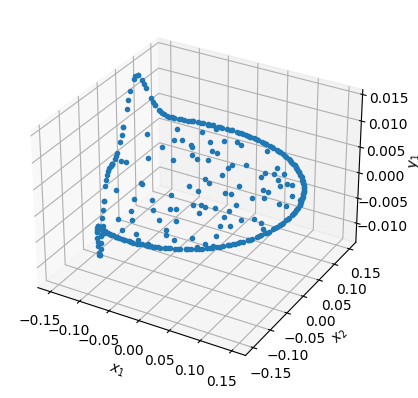

15
Compiling model...
Building feed-forward neural network...
'build' took 0.148998 s

'compile' took 4.658111 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.67e-04, 4.49e-01, 2.59e+00, 2.70e-01, 0.00e+00, 1.15e-01]    [2.90e-04, 4.49e-01, 2.59e+00, 2.70e-01, 0.00e+00, 1.32e-01]    []  
10000     [1.19e-03, 2.13e-05, 5.53e-04, 1.09e-03, 0.00e+00, 5.44e-04]    [6.85e-04, 2.13e-05, 5.53e-04, 1.09e-03, 0.00e+00, 6.47e-04]    []  
20000     [1.66e-04, 2.56e-06, 3.04e-05, 2.26e-04, 0.00e+00, 2.54e-04]    [1.00e-04, 2.56e-06, 3.04e-05, 2.26e-04, 0.00e+00, 1.37e-04]    []  
30000     [2.91e-04, 4.30e-05, 1.54e-04, 2.00e-04, 0.00e+00, 2.99e-03]    [1.42e-04, 4.30e-05, 1.54e-04, 2.00e-04, 0.00e+00, 2.16e-03]    []  

Best model at step 20000:
  train loss: 6.79e-04
  test loss: 4.97e-04
  test metric: []

'train' took 98.340554 s

Saving loss history to /cont

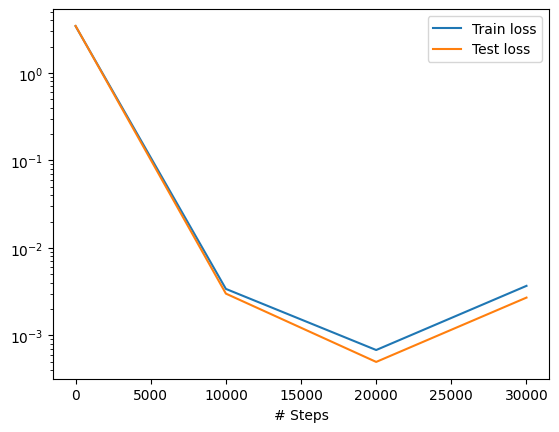

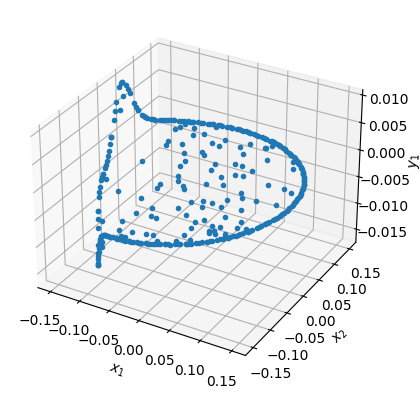

16
Compiling model...
Building feed-forward neural network...
'build' took 0.134889 s

'compile' took 3.838041 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.48e-04, 1.90e+00, 1.81e+00, 9.39e-04, 0.00e+00, 2.37e-04]    [1.20e-04, 1.90e+00, 1.81e+00, 9.39e-04, 0.00e+00, 2.28e-04]    []  
10000     [3.09e-03, 3.40e-03, 2.92e-03, 1.68e-03, 0.00e+00, 2.09e-03]    [2.27e-03, 3.40e-03, 2.92e-03, 1.68e-03, 0.00e+00, 1.47e-03]    []  
20000     [5.09e-04, 2.21e-04, 1.78e-05, 1.04e-03, 0.00e+00, 1.98e-03]    [3.98e-04, 2.21e-04, 1.78e-05, 1.04e-03, 0.00e+00, 1.60e-03]    []  
30000     [3.69e-04, 6.58e-08, 2.38e-07, 8.36e-04, 0.00e+00, 1.50e-03]    [4.89e-04, 6.58e-08, 2.38e-07, 8.36e-04, 0.00e+00, 9.20e-04]    []  

Best model at step 30000:
  train loss: 2.70e-03
  test loss: 2.25e-03
  test metric: []

'train' took 98.347427 s

Saving loss history to /cont

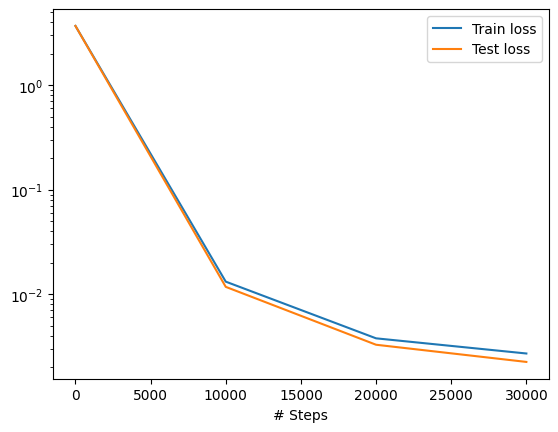

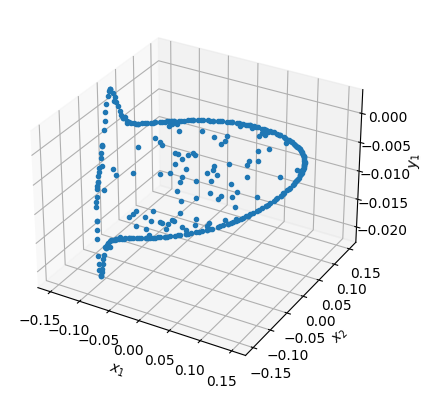

17
Compiling model...
Building feed-forward neural network...
'build' took 0.128774 s

'compile' took 3.916555 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.77e-04, 6.28e-01, 1.82e+00, 3.01e-01, 0.00e+00, 1.30e-01]    [4.26e-04, 6.28e-01, 1.82e+00, 3.01e-01, 0.00e+00, 6.55e-02]    []  
10000     [7.34e-04, 9.01e-05, 6.69e-05, 8.41e-04, 0.00e+00, 5.39e-04]    [5.81e-04, 9.01e-05, 6.69e-05, 8.41e-04, 0.00e+00, 5.89e-04]    []  
20000     [1.72e-04, 3.59e-05, 2.79e-05, 3.52e-04, 0.00e+00, 1.03e-03]    [1.63e-04, 3.59e-05, 2.79e-05, 3.52e-04, 0.00e+00, 1.19e-03]    []  
30000     [5.94e-04, 1.55e-04, 1.28e-04, 3.96e-04, 0.00e+00, 5.20e-04]    [1.13e-04, 1.55e-04, 1.28e-04, 3.96e-04, 0.00e+00, 6.05e-04]    []  

Best model at step 20000:
  train loss: 1.62e-03
  test loss: 1.77e-03
  test metric: []

'train' took 98.073293 s

Saving loss history to /cont

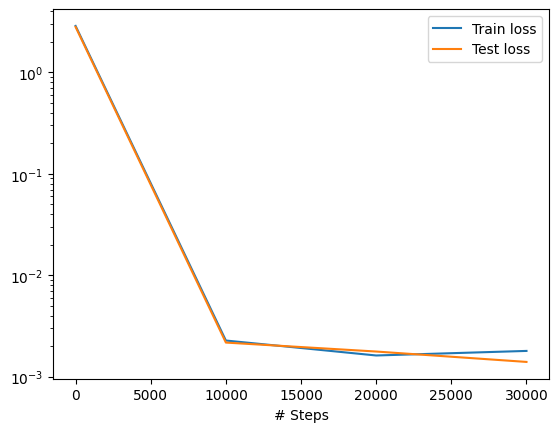

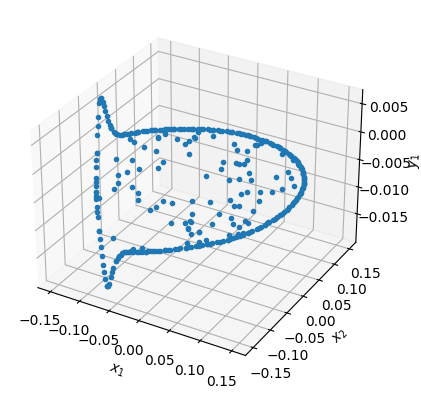

18
Compiling model...
Building feed-forward neural network...
'build' took 0.135158 s

'compile' took 4.624958 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.60e-05, 1.74e+00, 2.48e+00, 4.97e-02, 0.00e+00, 2.74e-03]    [1.27e-05, 1.74e+00, 2.48e+00, 4.97e-02, 0.00e+00, 1.53e-03]    []  
10000     [1.69e-03, 1.21e-04, 8.16e-05, 7.05e-04, 0.00e+00, 5.10e-04]    [5.36e-04, 1.21e-04, 8.16e-05, 7.05e-04, 0.00e+00, 1.47e-04]    []  
20000     [3.20e-04, 7.80e-06, 9.92e-08, 2.21e-04, 0.00e+00, 6.80e-04]    [1.12e-04, 7.80e-06, 9.91e-08, 2.21e-04, 0.00e+00, 8.85e-04]    []  
30000     [5.79e-04, 1.35e-06, 9.12e-06, 3.66e-04, 0.00e+00, 2.08e-04]    [8.53e-05, 1.35e-06, 9.12e-06, 3.66e-04, 0.00e+00, 1.38e-04]    []  

Best model at step 30000:
  train loss: 1.16e-03
  test loss: 6.01e-04
  test metric: []

'train' took 99.415253 s

Saving loss history to /cont

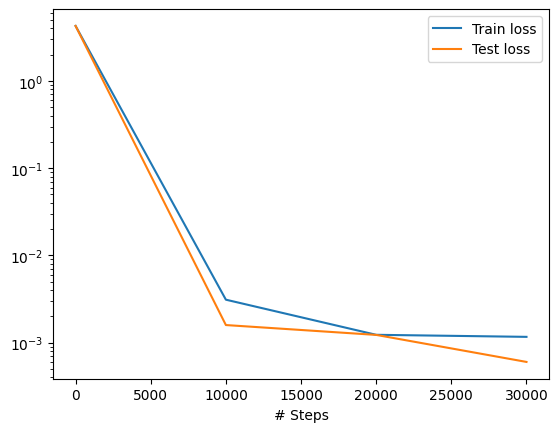

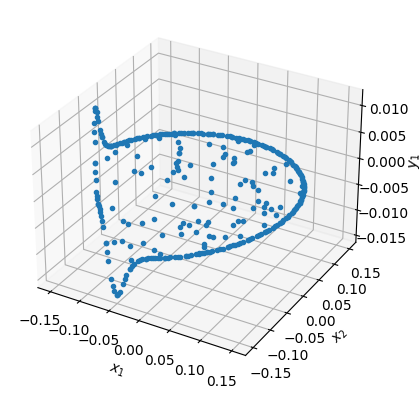

19
Compiling model...
Building feed-forward neural network...
'build' took 0.133229 s

'compile' took 4.150856 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.70e-04, 3.86e+00, 1.07e+00, 2.02e-01, 0.00e+00, 1.22e-01]    [3.09e-04, 3.86e+00, 1.07e+00, 2.02e-01, 0.00e+00, 8.54e-02]    []  
10000     [3.58e-04, 8.71e-05, 2.31e-05, 5.51e-04, 0.00e+00, 1.80e-04]    [2.40e-04, 8.71e-05, 2.31e-05, 5.51e-04, 0.00e+00, 7.31e-04]    []  
20000     [6.71e-04, 8.30e-05, 3.61e-05, 2.17e-04, 0.00e+00, 2.29e-04]    [3.36e-04, 8.30e-05, 3.61e-05, 2.17e-04, 0.00e+00, 9.50e-04]    []  
30000     [3.80e-04, 1.47e-05, 5.26e-05, 1.45e-04, 0.00e+00, 1.79e-04]    [1.78e-04, 1.47e-05, 5.26e-05, 1.45e-04, 0.00e+00, 8.63e-04]    []  

Best model at step 30000:
  train loss: 7.71e-04
  test loss: 1.25e-03
  test metric: []

'train' took 101.005706 s

Saving loss history to /con

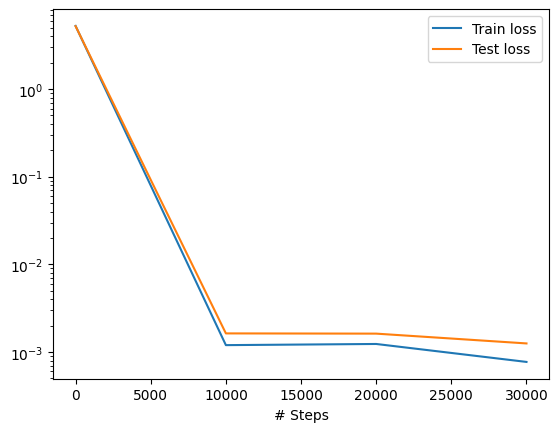

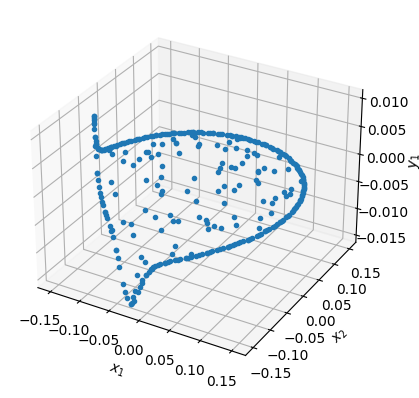

20
Compiling model...
Building feed-forward neural network...
'build' took 0.136352 s

'compile' took 5.070287 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.22e-04, 2.15e+00, 7.53e-01, 1.61e-01, 0.00e+00, 2.71e-02]    [1.71e-04, 2.15e+00, 7.53e-01, 1.61e-01, 0.00e+00, 1.36e-02]    []  
10000     [1.50e-03, 1.64e-04, 4.57e-04, 1.31e-03, 0.00e+00, 1.86e-04]    [1.93e-03, 1.64e-04, 4.57e-04, 1.31e-03, 0.00e+00, 1.15e-04]    []  
20000     [5.40e-04, 1.56e-06, 5.26e-05, 2.12e-04, 0.00e+00, 4.18e-03]    [3.02e-04, 1.56e-06, 5.26e-05, 2.12e-04, 0.00e+00, 4.28e-03]    []  
30000     [1.12e-04, 3.30e-04, 1.48e-04, 1.05e-04, 0.00e+00, 1.33e-04]    [9.31e-05, 3.30e-04, 1.48e-04, 1.05e-04, 0.00e+00, 1.02e-04]    []  

Best model at step 30000:
  train loss: 8.29e-04
  test loss: 7.79e-04
  test metric: []

'train' took 101.198932 s

Saving loss history to /con

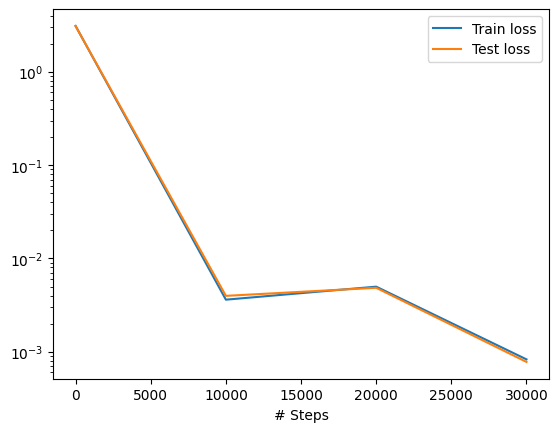

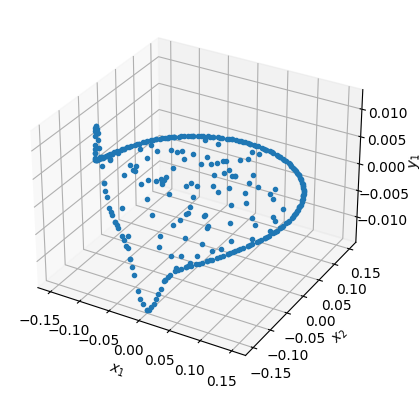

21
Compiling model...
Building feed-forward neural network...
'build' took 0.135699 s

'compile' took 4.162343 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.93e-03, 5.00e+00, 9.87e-01, 4.71e-01, 0.00e+00, 2.14e-01]    [1.39e-03, 5.00e+00, 9.87e-01, 4.71e-01, 0.00e+00, 1.23e-01]    []  
10000     [1.85e-03, 4.82e-05, 7.81e-06, 1.65e-03, 0.00e+00, 1.92e-04]    [5.23e-04, 4.82e-05, 7.81e-06, 1.65e-03, 0.00e+00, 1.04e-04]    []  
20000     [1.58e-04, 1.70e-04, 1.11e-04, 2.28e-04, 0.00e+00, 4.20e-04]    [5.16e-05, 1.70e-04, 1.11e-04, 2.28e-04, 0.00e+00, 3.30e-04]    []  
30000     [1.90e-03, 9.10e-05, 3.16e-04, 1.28e-04, 0.00e+00, 3.72e-03]    [2.50e-04, 9.10e-05, 3.16e-04, 1.28e-04, 0.00e+00, 4.04e-03]    []  

Best model at step 20000:
  train loss: 1.09e-03
  test loss: 8.91e-04
  test metric: []

'train' took 101.593451 s

Saving loss history to /con

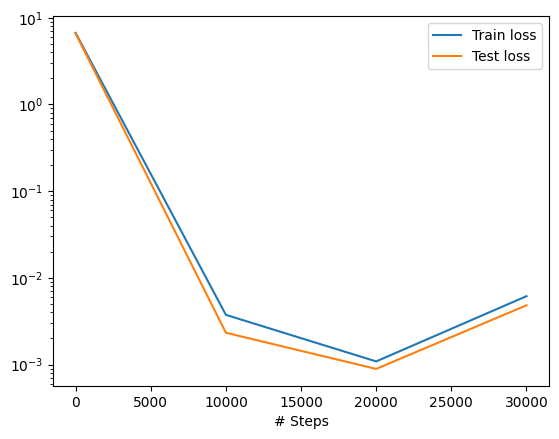

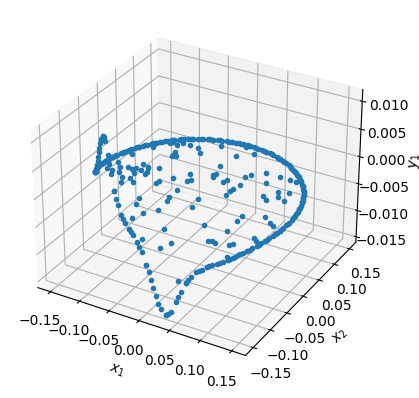

22
Compiling model...
Building feed-forward neural network...
'build' took 0.202641 s

'compile' took 4.821954 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.84e-04, 2.72e+00, 1.31e+00, 4.68e-02, 0.00e+00, 6.10e-03]    [1.14e-04, 2.72e+00, 1.31e+00, 4.68e-02, 0.00e+00, 5.70e-03]    []  
10000     [7.57e-03, 2.44e-03, 3.85e-03, 1.24e-03, 0.00e+00, 1.96e-04]    [2.93e-03, 2.44e-03, 3.85e-03, 1.24e-03, 0.00e+00, 2.74e-04]    []  
20000     [2.20e-04, 5.82e-05, 4.15e-06, 1.30e-04, 0.00e+00, 1.08e-04]    [7.61e-05, 5.82e-05, 4.15e-06, 1.30e-04, 0.00e+00, 3.24e-05]    []  
30000     [3.31e-04, 3.25e-04, 2.22e-04, 1.12e-04, 0.00e+00, 1.54e-04]    [1.04e-04, 3.25e-04, 2.22e-04, 1.12e-04, 0.00e+00, 1.16e-04]    []  

Best model at step 20000:
  train loss: 5.20e-04
  test loss: 3.01e-04
  test metric: []

'train' took 100.771754 s

Saving loss history to /con

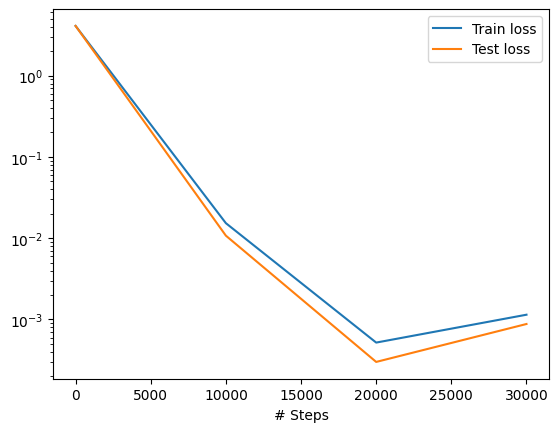

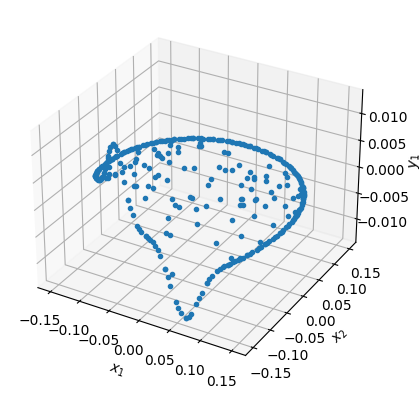

23
Compiling model...
Building feed-forward neural network...
'build' took 0.135595 s

'compile' took 8.295742 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.04e-04, 1.66e+00, 1.19e+00, 8.76e-02, 0.00e+00, 5.47e-02]    [8.50e-05, 1.66e+00, 1.19e+00, 8.76e-02, 0.00e+00, 2.87e-02]    []  
10000     [7.98e-04, 4.20e-05, 2.20e-04, 5.82e-04, 0.00e+00, 7.41e-05]    [7.64e-04, 4.20e-05, 2.20e-04, 5.82e-04, 0.00e+00, 2.33e-05]    []  
20000     [1.15e-04, 1.91e-04, 1.60e-04, 1.32e-04, 0.00e+00, 1.70e-04]    [1.62e-04, 1.91e-04, 1.60e-04, 1.32e-04, 0.00e+00, 6.54e-05]    []  
30000     [3.73e-04, 1.59e-05, 4.73e-06, 9.72e-05, 0.00e+00, 1.93e-04]    [2.54e-04, 1.59e-05, 4.73e-06, 9.72e-05, 0.00e+00, 6.59e-05]    []  

Best model at step 30000:
  train loss: 6.84e-04
  test loss: 4.38e-04
  test metric: []

'train' took 103.171530 s

Saving loss history to /con

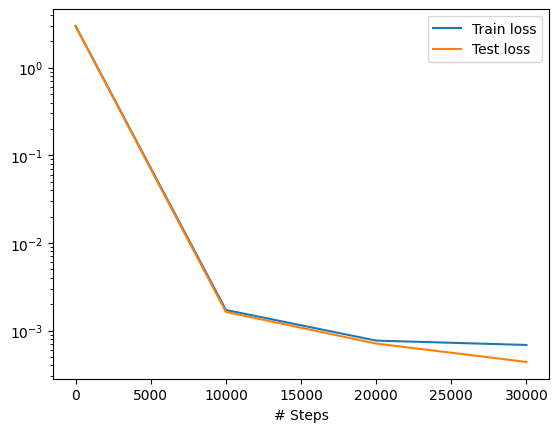

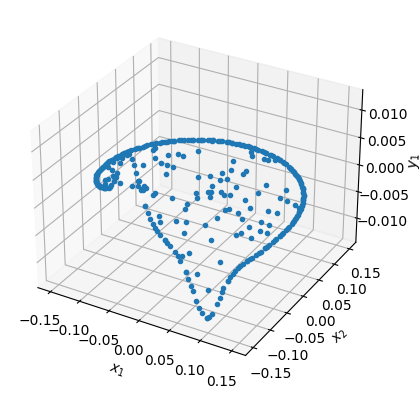

24
Compiling model...
Building feed-forward neural network...
'build' took 0.147855 s

'compile' took 4.392616 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.65e-04, 3.90e+00, 4.96e-01, 2.30e-01, 0.00e+00, 2.42e-02]    [3.05e-04, 3.90e+00, 4.96e-01, 2.30e-01, 0.00e+00, 3.77e-02]    []  
10000     [3.34e-03, 2.35e-04, 1.39e-03, 2.93e-03, 0.00e+00, 2.12e-04]    [1.50e-03, 2.35e-04, 1.39e-03, 2.93e-03, 0.00e+00, 7.00e-04]    []  
20000     [1.39e-04, 5.00e-06, 2.87e-08, 1.61e-04, 0.00e+00, 3.44e-04]    [5.81e-05, 5.00e-06, 2.87e-08, 1.61e-04, 0.00e+00, 4.30e-04]    []  
30000     [4.23e-04, 5.47e-05, 1.60e-04, 8.73e-05, 0.00e+00, 1.42e-04]    [1.28e-04, 5.47e-05, 1.60e-04, 8.73e-05, 0.00e+00, 5.78e-04]    []  

Best model at step 20000:
  train loss: 6.49e-04
  test loss: 6.54e-04
  test metric: []

'train' took 104.168445 s

Saving loss history to /con

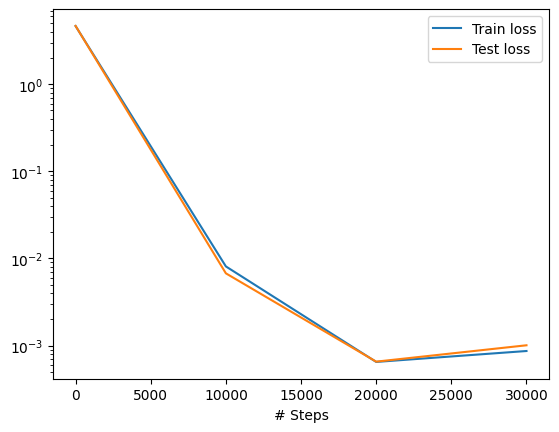

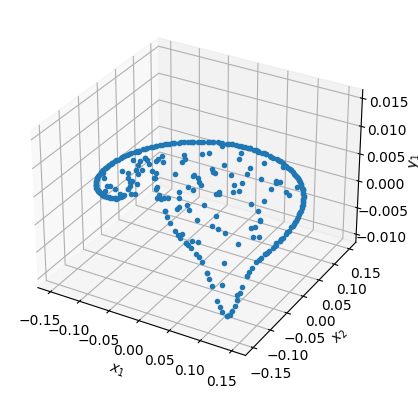

25
Compiling model...
Building feed-forward neural network...
'build' took 0.137050 s

'compile' took 4.483083 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.86e-03, 1.46e+00, 1.09e-01, 1.27e+00, 0.00e+00, 7.35e-01]    [2.94e-03, 1.46e+00, 1.09e-01, 1.27e+00, 0.00e+00, 3.74e-01]    []  
10000     [7.54e-04, 1.23e-03, 5.33e-04, 4.09e-04, 0.00e+00, 2.02e-04]    [5.51e-04, 1.23e-03, 5.33e-04, 4.09e-04, 0.00e+00, 3.68e-03]    []  
20000     [2.07e-03, 1.54e-04, 1.26e-04, 2.51e-04, 0.00e+00, 1.01e-03]    [1.16e-03, 1.54e-04, 1.26e-04, 2.51e-04, 0.00e+00, 2.25e-03]    []  
30000     [8.59e-04, 1.76e-07, 4.34e-05, 2.00e-04, 0.00e+00, 5.00e-04]    [1.98e-04, 1.76e-07, 4.34e-05, 2.00e-04, 0.00e+00, 6.67e-03]    []  

Best model at step 30000:
  train loss: 1.60e-03
  test loss: 7.11e-03
  test metric: []

'train' took 104.076498 s

Saving loss history to /con

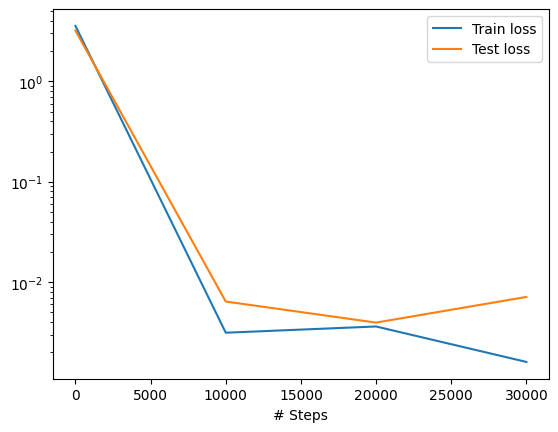

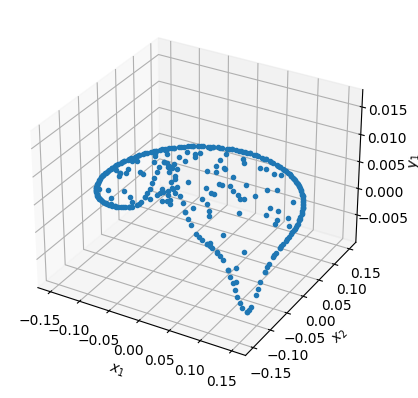

26
Compiling model...
Building feed-forward neural network...
'build' took 0.134743 s

'compile' took 4.502790 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.44e-04, 1.72e+00, 2.22e+00, 1.50e-02, 0.00e+00, 9.87e-03]    [1.90e-04, 1.72e+00, 2.22e+00, 1.50e-02, 0.00e+00, 4.94e-03]    []  
10000     [1.82e-03, 6.58e-04, 1.72e-04, 1.14e-03, 0.00e+00, 2.11e-04]    [5.29e-04, 6.58e-04, 1.72e-04, 1.14e-03, 0.00e+00, 5.84e-05]    []  
20000     [1.38e-03, 8.30e-05, 1.46e-04, 3.75e-04, 0.00e+00, 1.97e-03]    [6.74e-04, 8.30e-05, 1.46e-04, 3.75e-04, 0.00e+00, 2.86e-03]    []  
30000     [1.43e-03, 1.60e-04, 2.61e-08, 5.07e-04, 0.00e+00, 5.05e-04]    [8.12e-04, 1.60e-04, 2.61e-08, 5.07e-04, 0.00e+00, 8.58e-04]    []  

Best model at step 30000:
  train loss: 2.60e-03
  test loss: 2.34e-03
  test metric: []

'train' took 104.441339 s

Saving loss history to /con

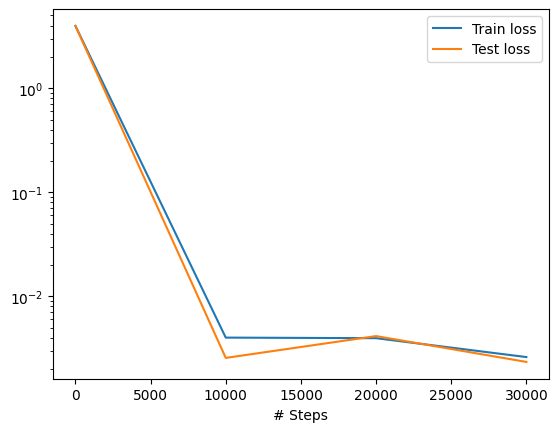

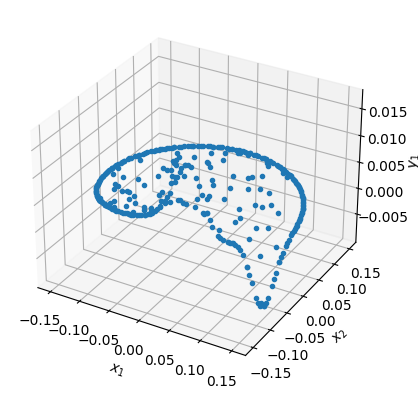

27
Compiling model...
Building feed-forward neural network...
'build' took 0.205078 s

'compile' took 5.382644 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.17e-04, 2.06e+00, 1.05e+00, 6.54e-02, 0.00e+00, 3.78e-02]    [1.01e-04, 2.06e+00, 1.05e+00, 6.54e-02, 0.00e+00, 3.27e-02]    []  
10000     [5.74e-04, 6.27e-05, 1.21e-04, 7.39e-04, 0.00e+00, 4.88e-04]    [3.73e-04, 6.27e-05, 1.21e-04, 7.39e-04, 0.00e+00, 4.39e-04]    []  
20000     [1.63e-04, 6.06e-07, 1.63e-05, 4.00e-04, 0.00e+00, 4.69e-04]    [1.28e-04, 6.06e-07, 1.63e-05, 4.00e-04, 0.00e+00, 6.76e-04]    []  
30000     [1.72e-03, 3.08e-06, 1.70e-04, 3.46e-04, 0.00e+00, 1.03e-03]    [4.04e-04, 3.08e-06, 1.70e-04, 3.46e-04, 0.00e+00, 2.02e-03]    []  

Best model at step 20000:
  train loss: 1.05e-03
  test loss: 1.22e-03
  test metric: []

'train' took 104.845077 s

Saving loss history to /con

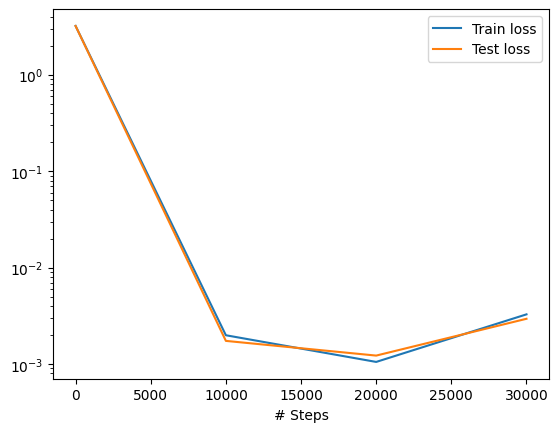

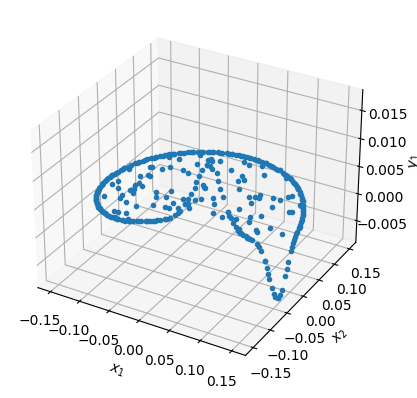

28
Compiling model...
Building feed-forward neural network...
'build' took 0.144620 s

'compile' took 5.490995 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.03e-03, 4.97e+00, 3.26e-01, 3.93e-01, 0.00e+00, 1.90e-01]    [8.86e-04, 4.97e+00, 3.26e-01, 3.93e-01, 0.00e+00, 1.32e-01]    []  
10000     [1.30e-03, 9.69e-04, 2.32e-03, 1.87e-03, 0.00e+00, 1.74e-03]    [6.10e-04, 9.69e-04, 2.32e-03, 1.87e-03, 0.00e+00, 2.57e-03]    []  
20000     [4.87e-04, 1.91e-05, 8.30e-05, 8.76e-04, 0.00e+00, 1.47e-03]    [5.32e-04, 1.91e-05, 8.30e-05, 8.76e-04, 0.00e+00, 1.67e-03]    []  
30000     [6.91e-04, 4.69e-05, 2.43e-05, 9.06e-04, 0.00e+00, 1.78e-03]    [6.33e-04, 4.69e-05, 2.43e-05, 9.06e-04, 0.00e+00, 3.30e-03]    []  

Best model at step 20000:
  train loss: 2.94e-03
  test loss: 3.18e-03
  test metric: []

'train' took 104.602120 s

Saving loss history to /con

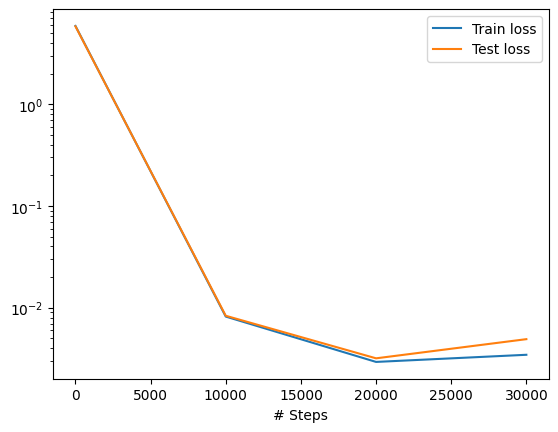

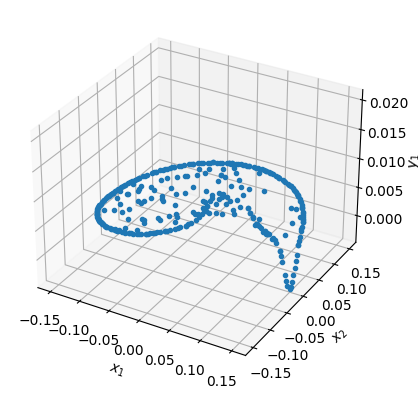

29
Compiling model...
Building feed-forward neural network...
'build' took 0.140457 s

'compile' took 9.850975 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.63e-04, 9.75e-01, 2.26e+00, 7.33e-02, 0.00e+00, 1.65e-02]    [2.04e-04, 9.75e-01, 2.26e+00, 7.33e-02, 0.00e+00, 2.46e-02]    []  
10000     [6.22e-03, 4.54e-04, 1.49e-03, 6.44e-02, 0.00e+00, 4.24e-03]    [4.27e-03, 4.54e-04, 1.49e-03, 6.44e-02, 0.00e+00, 1.09e-02]    []  
20000     [2.16e-03, 8.84e-04, 2.14e-04, 5.90e-04, 0.00e+00, 2.92e-04]    [1.26e-03, 8.84e-04, 2.14e-04, 5.90e-04, 0.00e+00, 1.81e-03]    []  
30000     [1.54e-04, 3.32e-05, 1.02e-04, 2.10e-04, 0.00e+00, 5.79e-04]    [7.15e-05, 3.32e-05, 1.02e-04, 2.10e-04, 0.00e+00, 7.03e-04]    []  

Best model at step 30000:
  train loss: 1.08e-03
  test loss: 1.12e-03
  test metric: []

'train' took 107.662700 s

Saving loss history to /con

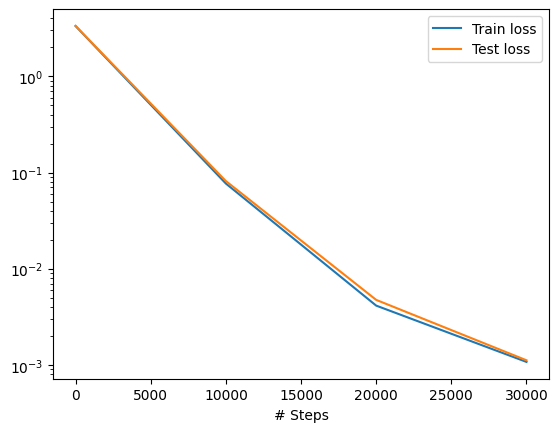

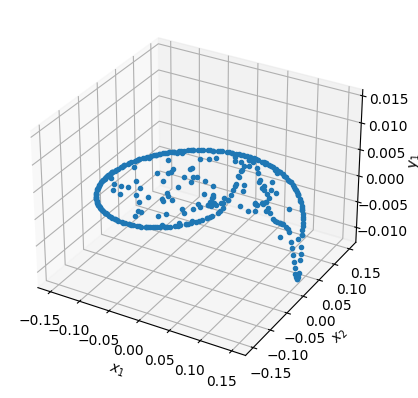

30
Compiling model...
Building feed-forward neural network...
'build' took 0.147151 s

'compile' took 4.806792 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.22e-03, 3.80e-02, 4.31e+00, 6.43e-01, 0.00e+00, 3.29e-01]    [8.73e-04, 3.80e-02, 4.31e+00, 6.43e-01, 0.00e+00, 1.65e-01]    []  
10000     [4.77e-03, 1.44e-04, 2.74e-03, 2.07e-03, 0.00e+00, 2.61e-04]    [2.50e-03, 1.44e-04, 2.74e-03, 2.07e-03, 0.00e+00, 6.75e-05]    []  
20000     [8.48e-03, 1.51e-03, 4.97e-04, 9.67e-04, 0.00e+00, 9.08e-04]    [5.86e-03, 1.51e-03, 4.97e-04, 9.67e-04, 0.00e+00, 1.28e-03]    []  
30000     [7.03e-04, 4.87e-04, 1.03e-04, 1.18e-04, 0.00e+00, 2.46e-04]    [4.06e-04, 4.87e-04, 1.03e-04, 1.18e-04, 0.00e+00, 2.59e-04]    []  

Best model at step 30000:
  train loss: 1.66e-03
  test loss: 1.37e-03
  test metric: []

'train' took 107.347535 s

Saving loss history to /con

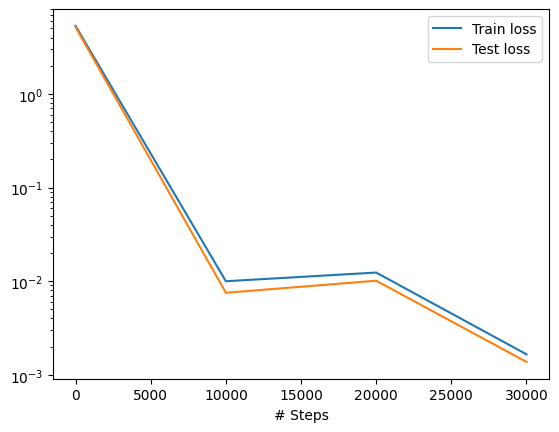

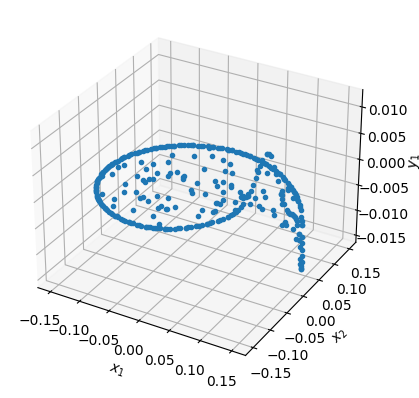

31
Compiling model...
Building feed-forward neural network...
'build' took 0.144739 s

'compile' took 4.831867 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.40e-04, 6.07e-01, 4.17e+00, 2.35e-01, 0.00e+00, 1.28e-01]    [2.83e-04, 6.07e-01, 4.17e+00, 2.35e-01, 0.00e+00, 7.78e-02]    []  
10000     [7.25e-04, 3.54e-04, 1.95e-04, 5.10e-04, 0.00e+00, 3.36e-04]    [2.97e-04, 3.54e-04, 1.95e-04, 5.10e-04, 0.00e+00, 4.50e-04]    []  
20000     [6.43e-03, 4.77e-03, 1.50e-03, 1.26e-01, 0.00e+00, 8.58e-03]    [5.21e-03, 4.77e-03, 1.50e-03, 1.26e-01, 0.00e+00, 9.75e-03]    []  
30000     [9.20e-04, 1.50e-04, 5.87e-05, 4.76e-04, 0.00e+00, 1.40e-03]    [3.84e-04, 1.50e-04, 5.87e-05, 4.76e-04, 0.00e+00, 3.17e-04]    []  

Best model at step 10000:
  train loss: 2.12e-03
  test loss: 1.81e-03
  test metric: []

'train' took 107.676463 s

Saving loss history to /con

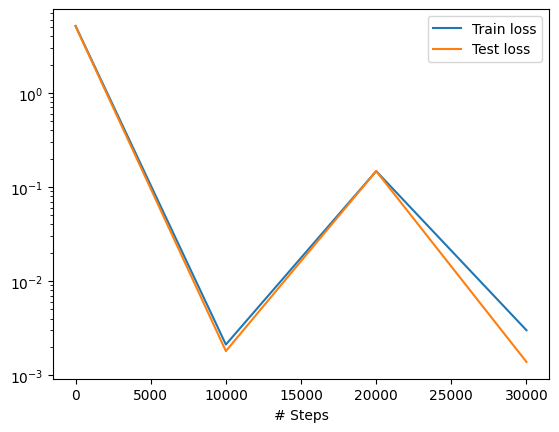

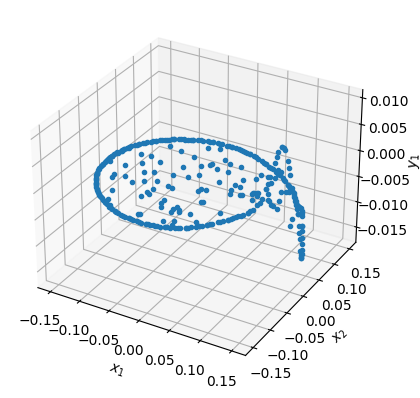

In [ ]:
# criando a geometria: uma circunferência
geom = dde.geometry.Disk([0,0], 0.15)

# criando os eletrodos
eletrodes = geom.uniform_boundary_points(32)

# lista com os potencias em cada experimento
eletric_potential = []

# selecionando o eletrodo de entrada de corrente elétrica
for i, entry_eletrode_values in enumerate(eletrodes):
  index_entry_eletrode = i
  index_exit_eletrode = index_entry_eletrode + 4 if index_entry_eletrode + 4 < np.shape(eletrodes)[0] else index_entry_eletrode + 4 - np.shape(eletrodes)[0]
  exit_eletrode_values = eletrodes[index_exit_eletrode]
  # convertendo listas em numpy arrays
  entry_eletrode_values = np.array([entry_eletrode_values])[0]
  exit_eletrode_values = np.array([exit_eletrode_values])[0]

  # testar se ele atualiza o valor do eletrodo de entrada e de saída
  best_model = neural_network(i, geom, eletrodes)
  eletric_potential.append(best_model.predict(eletrodes))

# Caminho para salvar o arquivo no Google Drive
caminho = 'caminho_para_salvar'

# Salvar a lista no arquivo
with open(caminho, 'wb') as arquivo:
    pickle.dump(eletric_potential, arquivo)